In [27]:
import pandas as pd

from create_csv import get_all_data

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

final_data, clicks = get_all_data()

def plot_subject_phase(final_data, all_clicks, subject_id: str, selected_phase: str):

    # Find where the x_axis should start and end

    #Grab the specific data we're talking about, this should maybe be abstracted one level above this function
    subject_data = final_data.loc[final_data['groupID'] == subject_id]
    plot_start = subject_data[selected_phase + '-start-time'].values[0]

    last_click = all_clicks[subject_id][selected_phase].max()
    phase_end = subject_data[selected_phase + '-end-time'].values[0]
    plot_end = max(last_click, phase_end)

    fig, ax = plt.subplots()

    ax.plot(all_clicks[subject_id])

    ax.set(xlim=(plot_start, plot_end), ylim=(0, 1))

    plt.show()


# plot_subject_phase(final_data, clicks, 'C-2857', 'beach')

phases = ['city', 'beach', 'airport']

def add_hit_miss_columns(data):
    for phase in phases:
        for alert in range(3):
            data[phase + '-alert' + str(alert) + '-hit'] = 0

def get_hit_miss(data, clicks, hit_threshold_ms):
    add_hit_miss_columns(data)
    for index, subject in data.iterrows():
        for phase in phases:
            subject_clicks_this_phase = clicks[subject['groupID']][phase].tolist()
            phase_start = subject[phase + '-start-time']
            for alert in subject[phase + '-alert-order']:
                alert_time = subject[phase + '-alert' + str(alert) + '-time']
                for click in subject_clicks_this_phase:
                    # Idiot check
                    if click < phase_start:
                        print("Ruh roh, how did the clicks happen before the phase started?")
                    if alert_time < click < (alert_time + hit_threshold_ms):
                        data.loc[index, phase + '-alert' + str(alert) + '-hit'] = 1
                        # data[index][phase + '-alert' + str(alert) + '-hit'] = 1
                        break


DEFAULT_HIT_THRESHOLD = 5000

get_hit_miss(final_data, clicks, DEFAULT_HIT_THRESHOLD)

print("done")


Error retrieving city-end-time from: 
Object:644057ba4a65a55c7447191b GroupID:A-8558
Error retrieving beach-end-time from: 
Object:644060395db95bbee031bb07 GroupID:B-5983
Error retrieving city-end-time from: 
Object:64406d6a9d88dcc1a74ed547 GroupID:C-366
Error retrieving beach-end-time from: 
Object:6440722c5b80d645c4596202 GroupID:D-3762
Error retrieving city-end-time from: 
Object:64407bcf0a830617c2d6525b GroupID:A-1676
Error retrieving beach-end-time from: 
Object:6442fbfa0139e7f9b5c8c8c5 GroupID:B-2695
Error retrieving city-end-time from: 
Object:6443025f435e57ed9db41922 GroupID:C-7434
Error retrieving beach-end-time from: 
Object:64430932368b5b5fb57a59d7 GroupID:D-9820
Error retrieving beach-end-time from: 
Object:6443143d7166151e87a9d726 GroupID:A-3801
Error retrieving city-end-time from: 
Object:64431a1058018c7549a04eda GroupID:B-4077
Error retrieving beach-end-time from: 
Object:64431e641ac6346e6c038a36 GroupID:C-2484
Error retrieving city-end-time from: 
Object:6446f0d463c0be0

In [28]:
def get_alert_average(data, alert):
    city = data['city-alert' + str(alert) + '-hit'].mean()
    beach = data['beach-alert' + str(alert) + '-hit'].mean()
    airport = data['beach-alert' + str(alert) + '-hit'].mean()
    return (city + beach + airport) / 3

def get_phase_average(data, phase: ['city', 'beach', 'airport']):
    a1 = data[phase + '-alert0-hit'].mean()
    a2 = data[phase + '-alert1-hit'].mean()
    a3 = data[phase + '-alert2-hit'].mean()
    return (a1 + a2 + a3) / 3

def plot_hit_rate_percentage(data):
    # for phase in phases:
    #     for alert in range(3):
    #         column = phase + '-alert' + str(alert) + '-hit'
    #         print(f"{column} average = {round(data[column].mean() * 100, 2)}%")
    print(f"Hit threshold = {DEFAULT_HIT_THRESHOLD}(ms)")

    for alert in range(3):
        average = get_alert_average(data, alert)
        print(f"Alert {alert} hit rate = {round(average * 100, 2)}%")

    for phase in phases:
        average = get_phase_average(data, phase)
        print(f"{phase} hit rate = {round(average * 100, 2)}%")


plot_hit_rate_percentage(final_data)

Alert 0 hit rate = 83.33%
Alert 1 hit rate = 84.85%
Alert 2 hit rate = 72.73%
city hit rate = 62.12%
beach hit rate = 89.39%
airport hit rate = 54.55%


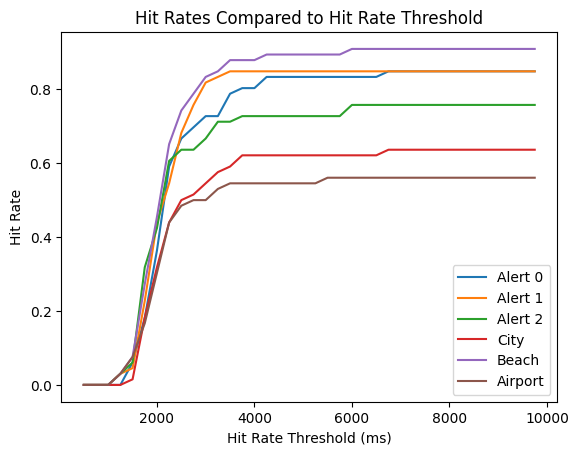

In [36]:
hit_thresholds = np.arange(500, 10000, 250)

hit_rates = pd.DataFrame(columns=['alert0', 'alert1', 'alert2', 'city', 'beach', 'airport'], index=hit_thresholds)
for threshold_index in range(len(hit_thresholds)):
    get_hit_miss(final_data, clicks, hit_thresholds[threshold_index])
    for alert in range(3):
        hit_rates.loc[hit_thresholds[threshold_index], 'alert' + str(alert)] = get_alert_average(final_data, alert)

    for phase in phases:
        hit_rates.loc[hit_thresholds[threshold_index], phase] = get_phase_average(final_data, phase)


plt.plot(hit_thresholds, hit_rates['alert0'], label='Alert 0')
plt.plot(hit_thresholds, hit_rates['alert1'], label='Alert 1')
plt.plot(hit_thresholds, hit_rates['alert2'], label='Alert 2')
plt.plot(hit_thresholds, hit_rates['city'], label='City')
plt.plot(hit_thresholds, hit_rates['beach'], label='Beach')
plt.plot(hit_thresholds, hit_rates['airport'], label='Airport')

plt.xlabel("Hit Rate Threshold (ms)")
plt.ylabel("Hit Rate")
plt.title("Hit Rates Compared to Hit Rate Threshold")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

plt.show()
